# Demonstration of the instability of likelihood-based training

In [1]:
%matplotlib inline

import numpy as np
from scipy.stats import norm
import matplotlib
from matplotlib import pyplot as plt


## "Training data"

In [2]:
n = 1000
x = np.vstack((np.zeros(n), np.random.normal(size=n))).T

## Model

In [3]:
def model(x, alpha, std):
    # Rotation matrix
    c, s = np.cos(alpha), np.sin(alpha)
    r = np.matrix([[c, s], [-s, s]])
    
    # Encode to latent space
    u, v = np.einsum("ij,ni->jn", r, x)
    
    # Density in latent space
    log_prob = np.mean(norm(loc=0, scale=std).logpdf(u))
    
    # Decode onto manifold
    uv_reco = np.vstack((u, np.zeros_like(v))).T
    x_reco = np.einsum("ji,ni->nj", r, uv_reco)
    
    # Reconstruction error
    delta_x = np.mean(np.sum((x_reco - x)**2, axis=1)**0.5)
    
    return log_prob, delta_x

## Evaluate model over a grid of parameters

In [4]:
res = 100

alpha_range = np.linspace(0., np.pi, res)
std_range = np.linspace(1.e-9, 1.5, res)
alpha_grid, std_grid = np.meshgrid(alpha_range, std_range)
alpha_grid = alpha_grid.flatten()
std_grid = std_grid.flatten()

log_prob_grid, delta_x_grid = [], []
for alpha, std in zip(alpha_grid, std_grid):
    log_prob, delta_x = model(x, alpha, std)
    log_prob_grid.append(log_prob)
    delta_x_grid.append(delta_x)
    
log_prob_grid = np.array(log_prob_grid).reshape(res, res)
delta_x_grid = np.array(delta_x_grid).reshape(res, res)

## Plot result

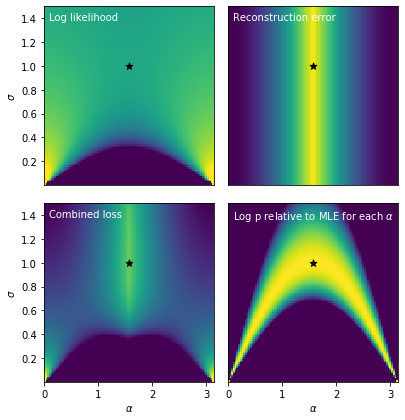

In [24]:
label_kwargs={"ha":"left", "va":"top", "x":0.08, "y":1.45, "c":"white", "fontsize":10.}
plt.figure(figsize=(6,6))

ax = plt.subplot(2,2,1)
zmin, zmax = -5., 1.
im = plt.imshow(
    np.clip(log_prob_grid, zmin, zmax),
    extent=(0., np.pi, 1.e-6, 1.5),
    origin="lower",
    cmap="viridis",
    norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest',
    aspect="auto"
)
plt.scatter([0.5*np.pi],[1.], marker="*", s=50., c="black")
plt.text(s="Log likelihood", **label_kwargs)
plt.xlim(0., np.pi)
plt.ylim(1.e-6, 1.5)
plt.ylabel(r"$\sigma$")
ax.get_xaxis().set_visible(False)

ax = plt.subplot(2,2,2)
zmin, zmax = 0.,0.8
im = plt.imshow(
    np.clip(delta_x_grid, zmin, zmax),
    extent=(0., np.pi, 1.e-6, 1.5),
    origin="lower",
    cmap="viridis_r",
    norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest',
    aspect="auto"
)
plt.scatter([0.5*np.pi],[1.], marker="*", s=50., c="black")
plt.text(s="Reconstruction error", **label_kwargs)
plt.xlim(0., np.pi)
plt.ylim(1.e-6, 1.5)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,2,3)
zmin, zmax = 0.2,1.2
im = plt.imshow(
    np.clip(delta_x_grid - 0.3 * log_prob_grid, zmin, zmax),
    extent=(0., np.pi, 1.e-6, 1.5),
    origin="lower",
    cmap="viridis_r",
    norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest',
    aspect="auto"
)
plt.scatter([0.5*np.pi],[1.], marker="*", s=50., c="black")
plt.text(s="Combined loss", **label_kwargs)
plt.xlim(0., np.pi)
plt.ylim(1.e-6, 1.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\sigma$")

ax = plt.subplot(2,2,4)
zmin, zmax = -0.2, 0.
im = plt.imshow(
    np.clip(log_prob_grid - np.max(log_prob_grid, axis=0)[np.newaxis, :], zmin, zmax),
    extent=(0., np.pi, 1.e-6, 1.5),
    origin="lower",
    cmap="viridis",
    norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest',
    aspect="auto"
)
plt.scatter([0.5*np.pi],[1.], marker="*", s=50., c="black")
plt.text(s=r"Log p relative to MLE for each $\alpha$", **label_kwargs)
plt.xlim(0., np.pi)
plt.ylim(1.e-6, 1.5)
plt.xlabel(r"$\alpha$")
ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.savefig("../figures/instability_demo_losses.pdf")

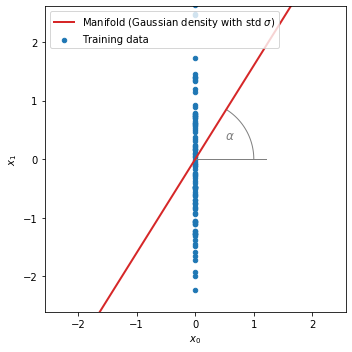

In [8]:
plt.figure(figsize=(5,5))
ax = plt.gca()

plt.plot([0, 1.2], [0, 0], c="0.5", lw=1.)
angles=np.linspace(0,np.arctan(8./5.), 100)
plt.plot(np.cos(angles), np.sin(angles), c="0.5", lw=1.)
plt.text(0.6, 0.4, r"$\alpha$", c="0.5", fontsize=12, ha="center", va="center")
plt.scatter(x[:100,0], x[:100,1], s=20., c="C0", label="Training data")
plt.plot([-5, 5], [-8, 8], c="C3", lw=2., label=r"Manifold (Gaussian density with std $\sigma$)")
# plt.plot([], [], c="white", ls=" ", label=r"  (Gaussian density with std $\sigma$)")
plt.legend(loc="upper left")
ax.axis("equal")
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.xlabel(r"$x_0$")
plt.ylabel(r"$x_1$")

plt.tight_layout()
plt.savefig("../figures/instability_demo_setup.pdf")
